In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

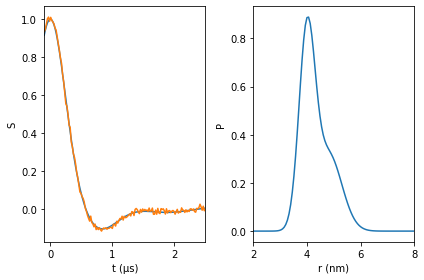

In [2]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
P0 = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P0 = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r)    # kernel matrix
sigma = 0.01

S0 = K@P0
S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Add custom sampling step for P

In [8]:
from pymc3.step_methods.arraystep import BlockedStep

class SampleRandP(BlockedStep):
    def __init__(self, var, delta, sigma, KtK, KtS, LtL, nr):
            self.vars = [var]
            self.var = var
            self.delta = delta
            self.sigma = sigma
            self.KtK = KtK
            self.KtS = KtS
            self.LtL = LtL
            self.nr = nr

    def step(self, point: dict):
        sigma = np.exp(point[self.sigma.transformed.name])
        tau = 1/(sigma**2)
        delta = np.exp(point[self.delta.transformed.name])
       
        new = point.copy()
        new[self.var.name] = dive.randP(delta,tau,self.KtK,self.KtS,self.LtL,self.nr)

        return new

### Setup model

In [3]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = P0

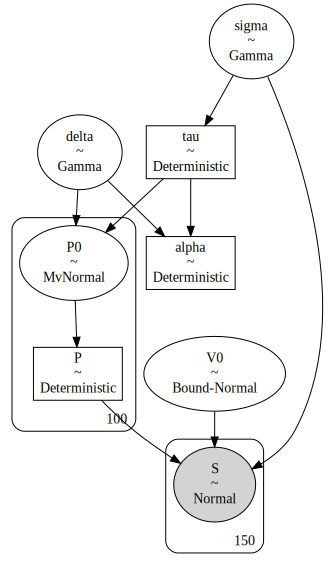

In [18]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    alpha = pm.Deterministic('alpha',np.sqrt(delta/tau))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

### Run sampler

In [20]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    trace = pm.sample(step = step_P0, chains=4, cores=1, draws=8000, tune=4000,return_inferencedata=False)

Sequential sampling (4 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [V0, delta, sigma]


Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 940 seconds.


### Analysis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V₀,1.019,0.006,1.008,1.029,0.000,0.000,18312.0,18333.0,1.0
σ,0.015,0.002,0.011,0.019,0.000,0.000,14408.0,18296.0,1.0
τ,4743.702,1250.981,2547.769,7179.356,10.426,7.373,14408.0,18296.0,1.0
δ,2207.343,587.100,1186.331,3331.971,4.503,3.184,16358.0,16865.0,1.0
alpha,0.693,0.120,0.471,0.917,0.001,0.001,12615.0,14705.0,1.0


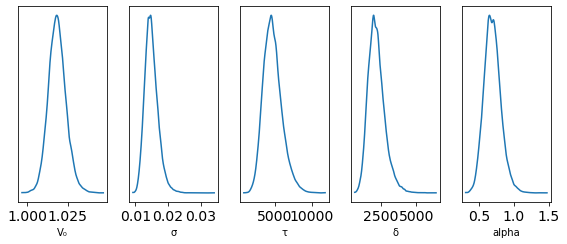

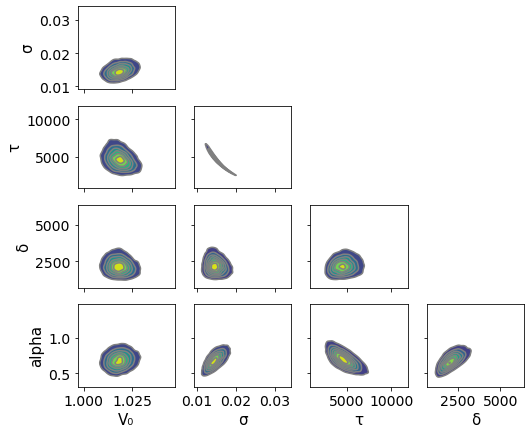

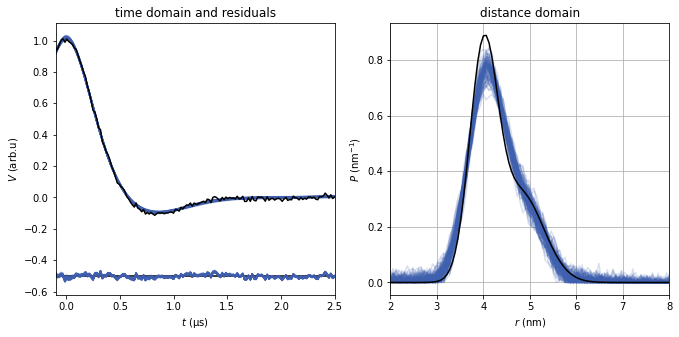

In [21]:
dive.summary(trace, model, S, t, r, Ptrue = Pmap)

### Same but more noise

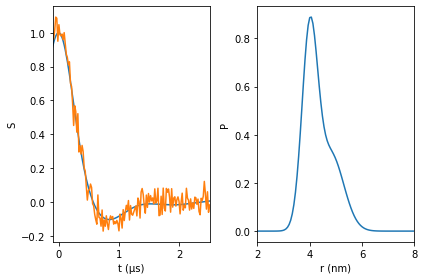

In [4]:
param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P0 = dl.dd_gauss2(r,param2)  

sigma = 0.05

S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [5]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

# These parameters are only used for the definition of P0 as a pymc3 variable
Pmap = P0

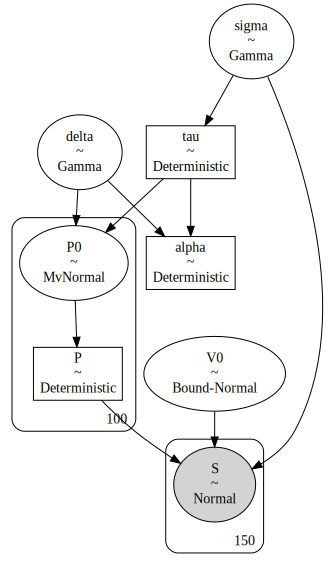

In [6]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    alpha = pm.Deterministic('alpha',np.sqrt(delta/tau))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [7]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    noisy_trace = pm.sample(step = step_P0, chains=2, cores=1, draws=4000, tune=2000,return_inferencedata=False)

NameError: name 'SampleRandP' is not defined

In [ ]:
dive.summary(noisy_trace, model, S, t, r, Ptrue = Pmap)